# Credit risk prediction

## 1. Introduction

<p>In this notebook, we'll tackle the task of credit risk prediction using the XGBoost (eXtreme Gradient Boosting) algorithm. Our aim is to develop a model that can accurately assess the creditworthiness of individuals based on their financial and personal information. We'll follow a standard machine learning workflow, including data loading, exploratory data analysis (EDA), preprocessing, model building, hyperparameter tuning, and evaluation.</p>

## 2. Data Loading and Inspection

In [1]:
%pip install pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('german_credit.csv')

# Display the first few rows
print("First 5 rows:")
%pip install tabulate
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Get information about the data
print("\nData information:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isna().sum().to_markdown(numalign="left", stralign="left"))


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
First 5 rows:
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
| Creditability   | Account Balance   | Duration of Credit (month)   | Payment Status of Previous Credit   | Purpose   | Credit Amount   | Value Savings/Stocks   | Length of current employment   | Instalment per cent   | Sex & Marital Status   | Guarantors   | Duration in Current address   | Most valuable available asset   | Age (years)   | Concurrent Credits   | Type of apartment   | No of Credits at this Bank   | Occupation   | No o

## 3. Exploratory Data Analysis (EDA)


Summary statistics:
|       | Creditability   | Account Balance   | Duration of Credit (month)   | Payment Status of Previous Credit   | Purpose   | Credit Amount   | Value Savings/Stocks   | Length of current employment   | Instalment per cent   | Sex & Marital Status   | Guarantors   | Duration in Current address   | Most valuable available asset   | Age (years)   | Concurrent Credits   | Type of apartment   | No of Credits at this Bank   | Occupation   | No of dependents   | Telephone   | Foreign Worker   |
|:------|:----------------|:------------------|:-----------------------------|:------------------------------------|:----------|:----------------|:-----------------------|:-------------------------------|:----------------------|:-----------------------|:-------------|:------------------------------|:--------------------------------|:--------------|:---------------------|:--------------------|:-----------------------------|:-------------|:-------------------|:------------|:------

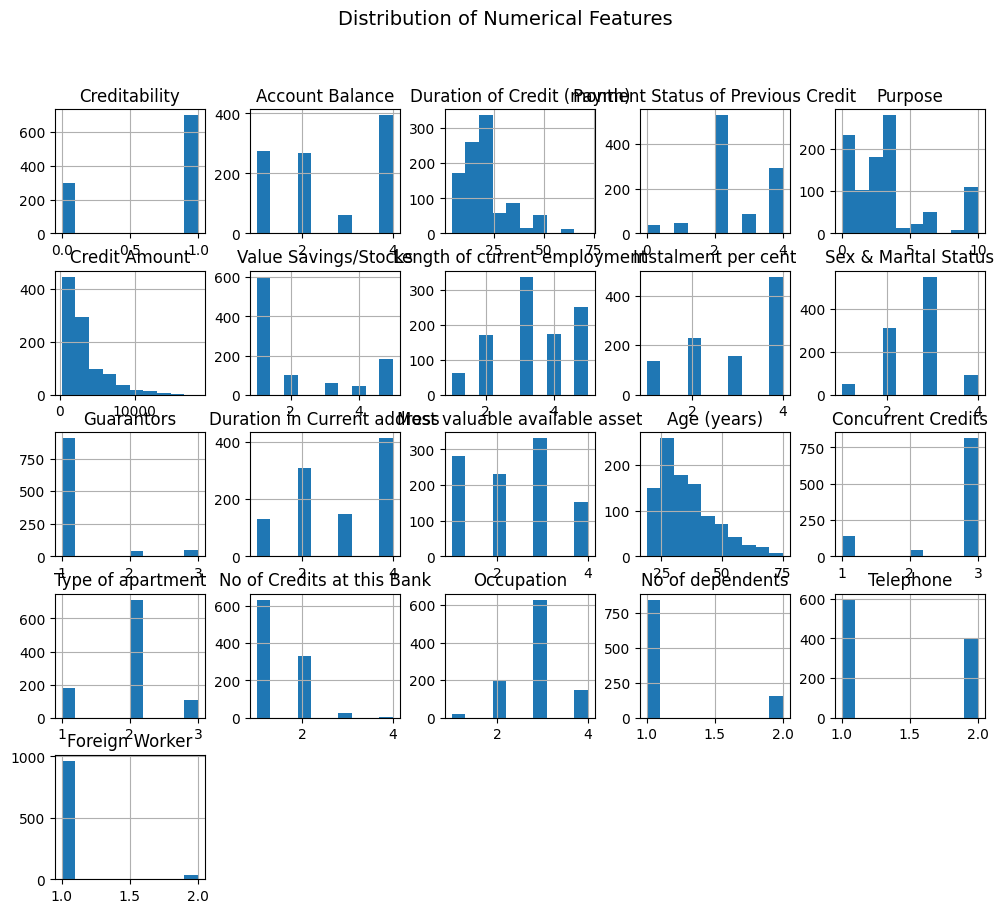

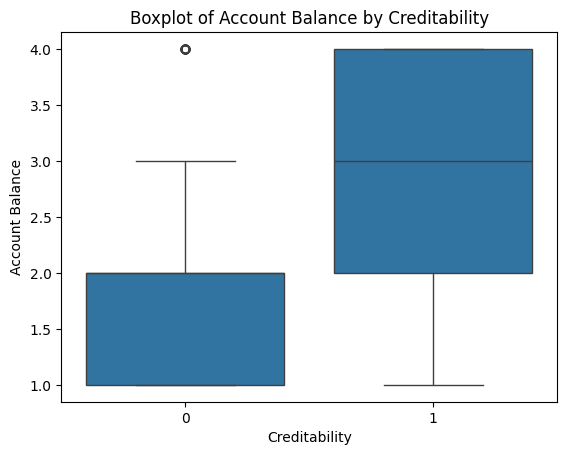

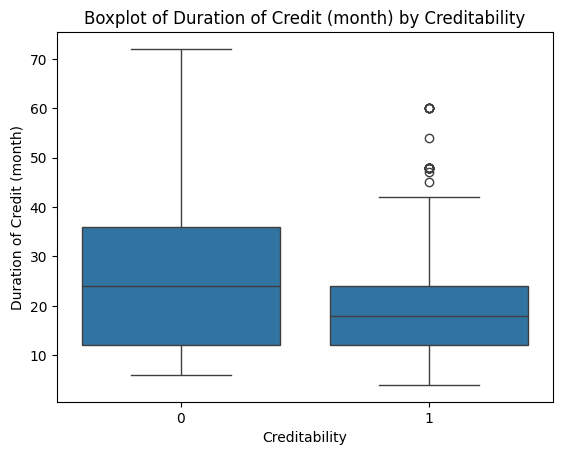

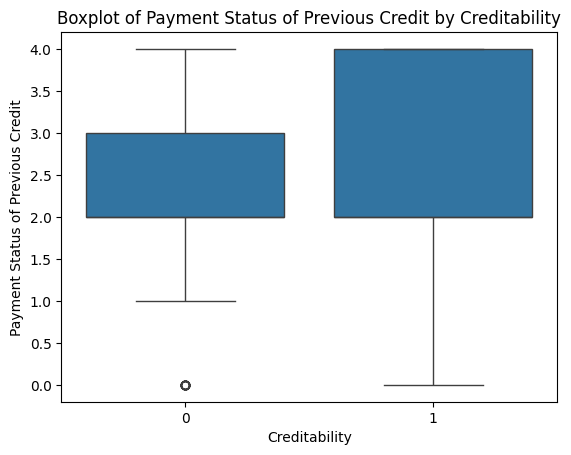

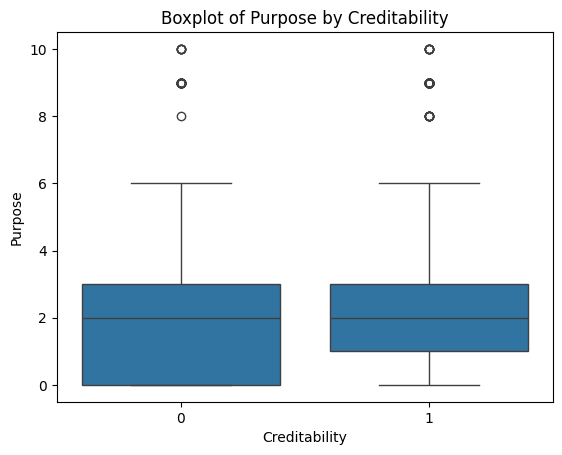

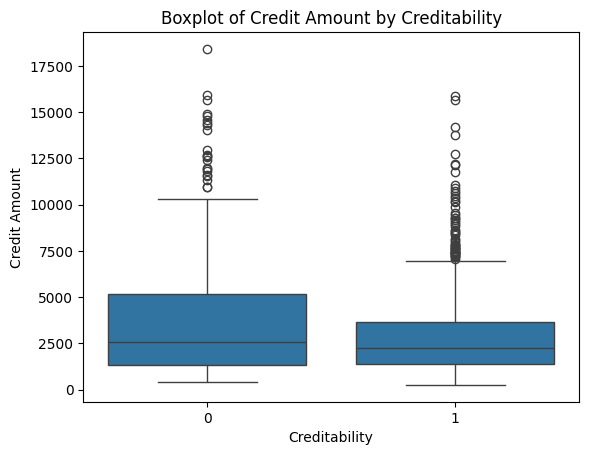

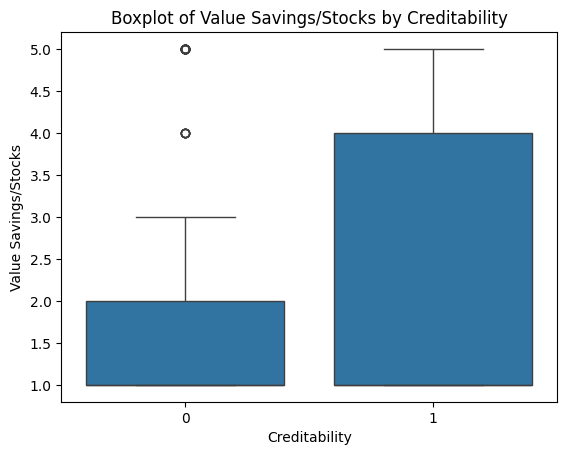

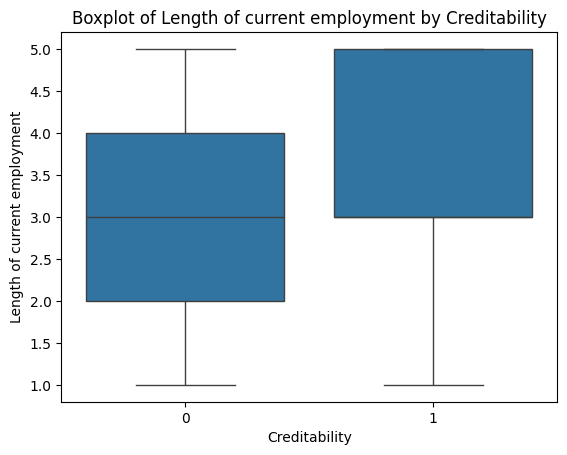

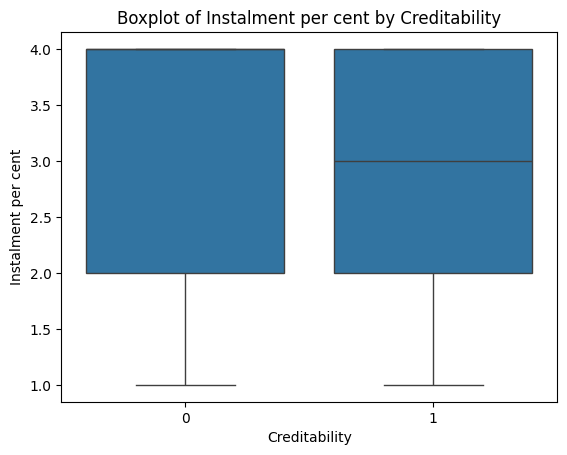

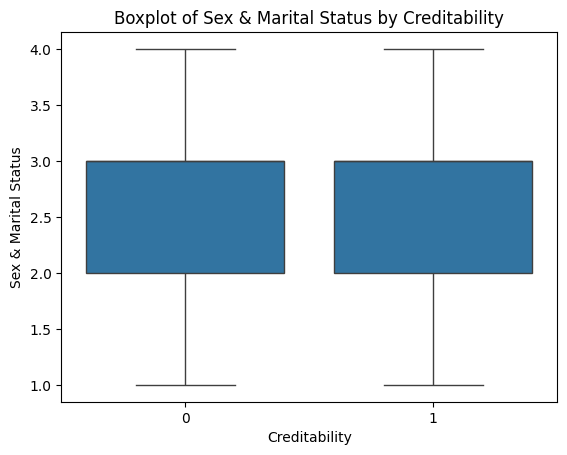

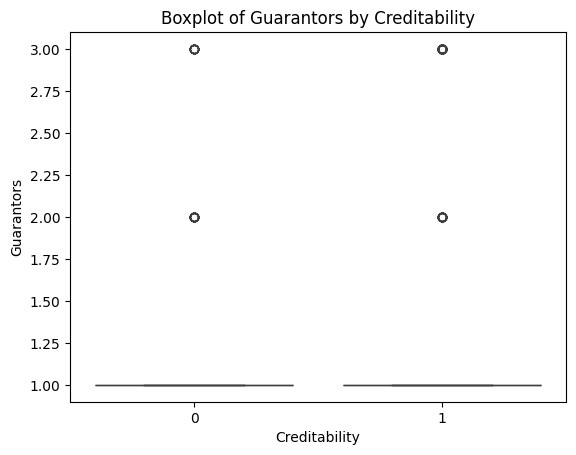

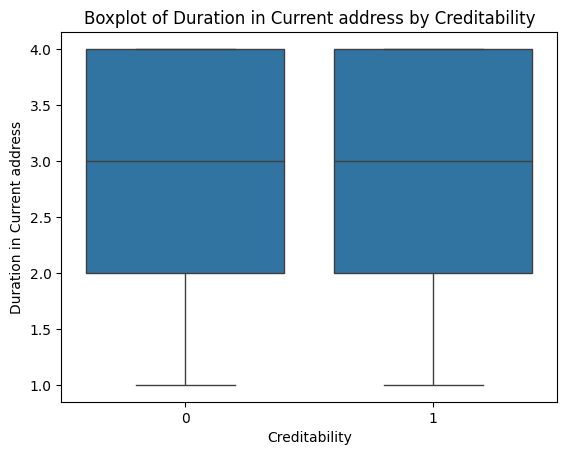

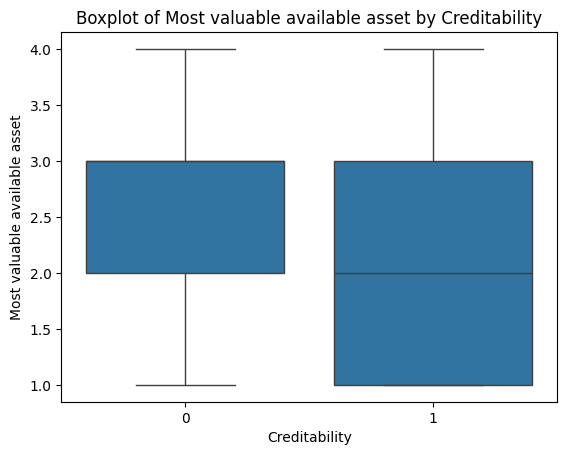

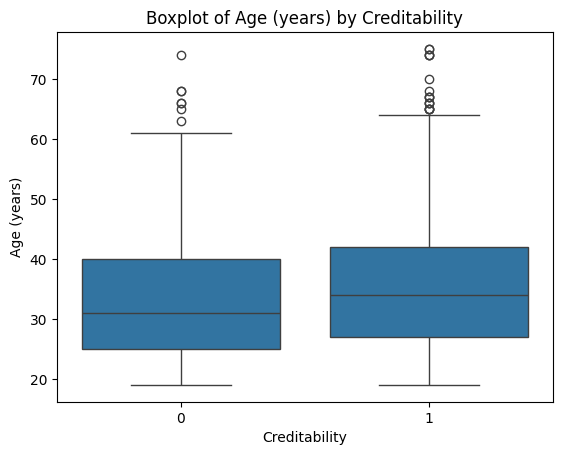

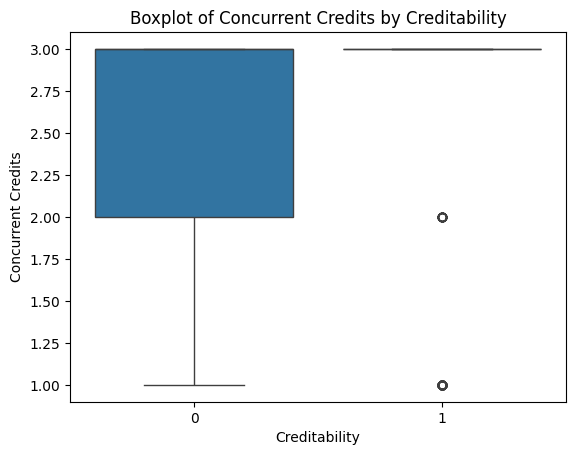

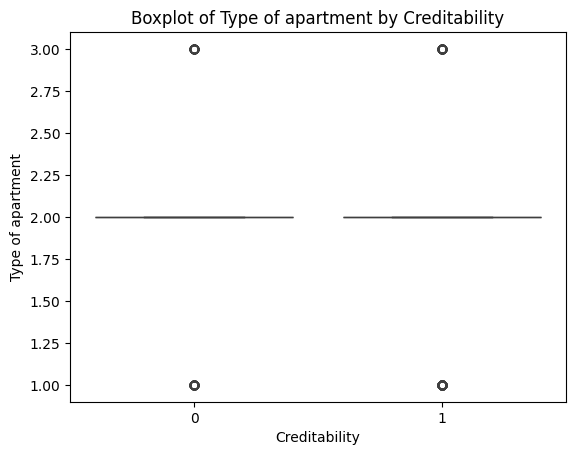

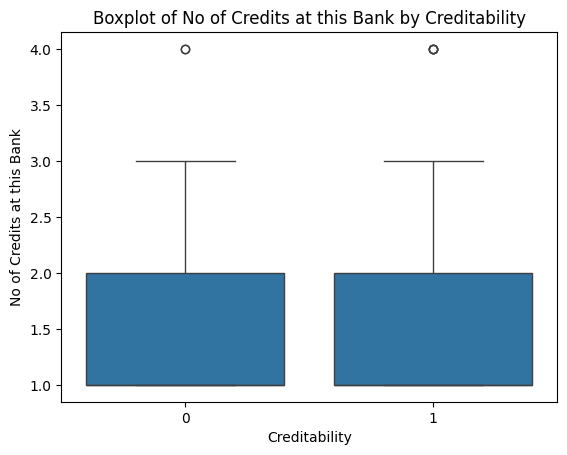

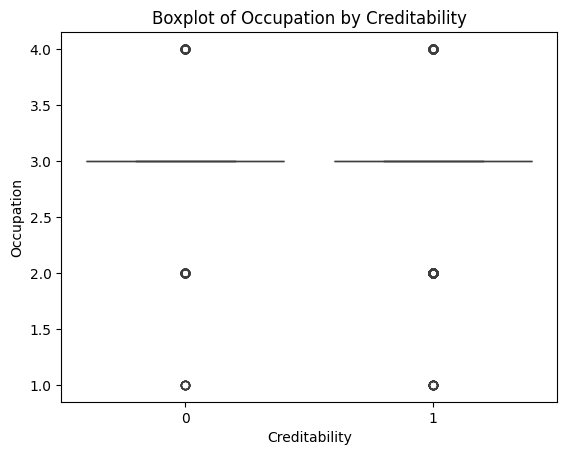

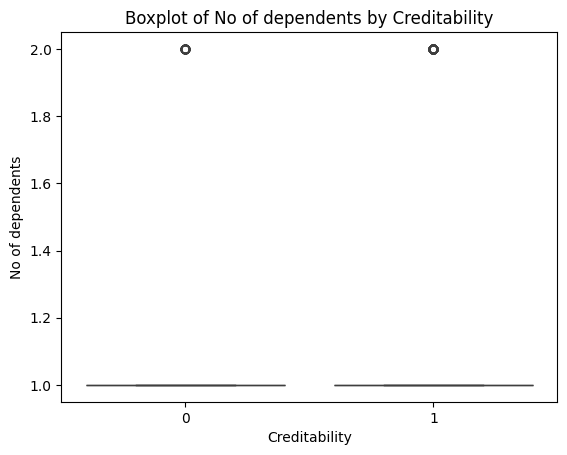

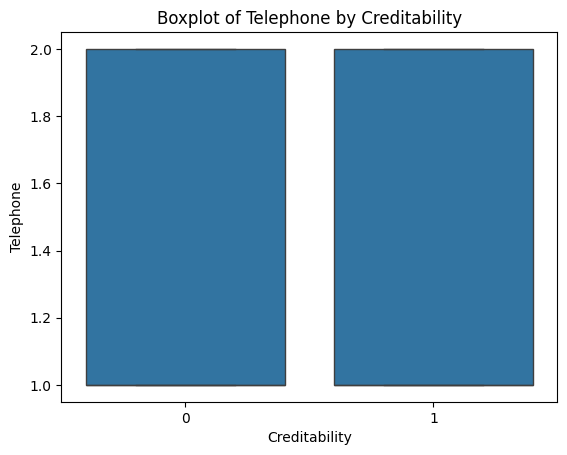

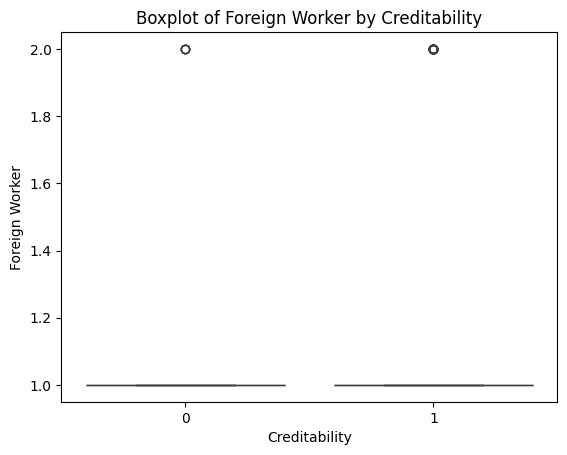

In [2]:
# Summary statistics
print("\nSummary statistics:")
print(df.describe().round(2).to_markdown(numalign="left", stralign="left"))

# Class distribution
print("\nTarget variable distribution:")
print(df['Creditability'].value_counts().to_markdown(numalign="left", stralign="left"))

# Visualize distributions of numerical features
df.hist(figsize=(12, 10))
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.show()

# Visualize relationships between features and target
for col in df.select_dtypes(include='number').columns:
    if col != 'Creditability':
        sns.boxplot(x='Creditability', y=col, data=df)
        plt.title(f'Boxplot of {col} by Creditability')
        plt.show()


## 4. Data Preprocessing

In [11]:
%pip install scikit-learn==1.2.2
%pip install -U imbalanced-learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

cat_features = X.select_dtypes(include=['object', 'category']).columns

# Label encode categorical features
for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features (optional, but often beneficial for XGBoost)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Address class imbalance (if necessary)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name '_get_column_indices' from 'sklearn.utils' (/Users/mac/Library/Python/3.9/lib/python/site-packages/sklearn/utils/__init__.py)

## 5. Model Building (XGBoost)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define XGBoost model
xgb = XGBClassifier(random_state=42, objective='binary:logistic')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Get the best model
best_xgb = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test)


## 6. Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))